In [1]:
import pandas as pd
import numpy as np


In [2]:
# Load CM1 dataset
cm1_df = pd.read_csv("../data/cm1.csv")

# Display first few rows
cm1_df.head()


,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,2,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,3,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,...,1,0,6,0,15.0,15.0,44.0,19.0,9.0,False
3,4,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,...,0,0,3,0,16.0,8.0,31.0,16.0,7.0,False
4,5,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False


In [3]:
# Extract module IDs
module_ids = cm1_df["id"].tolist()

# Check count
len(module_ids)


498

In [4]:
# Number of simulated test cases
num_test_cases = 100

# Create test case IDs
test_cases = [f"TC_{i:02d}" for i in range(1, num_test_cases + 1)]

test_cases[:5]


['TC_01', 'TC_02', 'TC_03', 'TC_04', 'TC_05']

In [5]:
np.random.seed(42)


In [6]:
mapping_rows = []

for tc in test_cases:
    # Each test case covers 1 to 3 modules
    num_modules = np.random.randint(1, 4)
    
    covered_modules = np.random.choice(
        module_ids, size=num_modules, replace=False
    )
    
    for module in covered_modules:
        mapping_rows.append({
            "test_id": tc,
            "module_id": module
        })

mapping_df = pd.DataFrame(mapping_rows)
mapping_df.head()


,test_id,module_id
0,TC_01,461
1,TC_01,74
2,TC_01,232
3,TC_02,243
4,TC_02,498


In [8]:
# Number of rows
mapping_df.shape

mapping_df["test_id"].nunique()


100

In [9]:
mapping_df.to_csv("../data/simulated_test_mapping.csv", index=False)

print("simulated_test_mapping.csv created successfully.")


simulated_test_mapping.csv created successfully.


In [10]:
import pandas as pd
import numpy as np


In [11]:
# Load datasets
cm1_df = pd.read_csv("../data/cm1.csv")
mapping_df = pd.read_csv("../data/simulated_test_mapping.csv")

cm1_df.head(), mapping_df.head()


(   id   loc  v(g)  ev(g)  iv(g)     n       v     l      d      i  ...  \
 0   1   1.1   1.4    1.4    1.4   1.3    1.30  1.30   1.30   1.30  ...   
 1   2   1.0   1.0    1.0    1.0   1.0    1.00  1.00   1.00   1.00  ...   
 2   3  24.0   5.0    1.0    3.0  63.0  309.13  0.11   9.50  32.54  ...   
 3   4  20.0   4.0    4.0    2.0  47.0  215.49  0.06  16.00  13.47  ...   
 4   5  24.0   6.0    6.0    2.0  72.0  346.13  0.06  17.33  19.97  ...   
 
    lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
 0       2          2        2                  2      1.2        1.2   
 1       1          1        1                  1      1.0        1.0   
 2       1          0        6                  0     15.0       15.0   
 3       0          0        3                  0     16.0        8.0   
 4       0          0        3                  0     16.0       12.0   
 
    total_Op  total_Opnd  branchCount  defects  
 0       1.2         1.2          1.4    False  
 1       1

In [12]:
# Drop non-feature columns
X = cm1_df.drop(columns=["id", "defects"])
y = cm1_df["defects"]


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
from sklearn.linear_model import LogisticRegression

risk_model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

risk_model.fit(X_scaled, y)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [15]:
# Predict defect probabilities
module_risk_scores = risk_model.predict_proba(X_scaled)[:, 1]

# Create DataFrame with module ID and risk score
risk_df = pd.DataFrame({
    "module_id": cm1_df["id"],
    "risk_score": module_risk_scores
})

risk_df.head()


,module_id,risk_score
0,1,0.998640
1,2,0.770172
2,3,0.318621
3,4,0.328499
4,5,0.241371


In [16]:
merged_df = mapping_df.merge(
    risk_df,
    on="module_id",
    how="left"
)

merged_df.head()


,test_id,module_id,risk_score
0,TC_01,461,0.336827
1,TC_01,74,0.762911
2,TC_01,232,0.204196
3,TC_02,243,0.206701
4,TC_02,498,0.499100


In [17]:
test_risk_df = (
    merged_df
    .groupby("test_id")["risk_score"]
    .sum()
    .reset_index()
    .rename(columns={"risk_score": "test_risk_score"})
)

test_risk_df.head()


,test_id,test_risk_score
0,TC_01,1.303933
1,TC_02,1.654680
2,TC_03,1.134289
3,TC_04,1.499336
4,TC_05,0.815120


In [18]:
prioritized_tests = test_risk_df.sort_values(
    by="test_risk_score",
    ascending=False
)

prioritized_tests.head(10)


,test_id,test_risk_score
54,TC_54,2.254449
8,TC_09,2.233676
33,TC_33,1.743398
15,TC_15,1.720704
1,TC_02,1.654680
65,TC_65,1.580073
41,TC_41,1.525604
3,TC_04,1.499336
36,TC_36,1.451930
82,TC_82,1.446682


In [19]:
# Identify defective modules
defective_modules = cm1_df[cm1_df["defects"] == True]["id"].tolist()

len(defective_modules)


49

In [20]:
# For each test case, check if it detects any defect
test_defect_map = (
    merged_df[merged_df["module_id"].isin(defective_modules)]
    .groupby("test_id")["module_id"]
    .apply(list)
    .to_dict()
)

list(test_defect_map.items())[:5]


[('TC_01', [461]),
 ('TC_02', [498]),
 ('TC_04', [476]),
 ('TC_05', [492]),
 ('TC_11', [495])]

In [22]:
def calculate_apfd(test_order, test_defect_map):
    n = len(test_order)
    defects = set()
    
    for mods in test_defect_map.values():
        defects.update(mods)
    
    m = len(defects)
    
    if m == 0:
        return 0
    
    tf_sum = 0
    for defect in defects:
        for idx, test in enumerate(test_order):
            if defect in test_defect_map.get(test, []):
                tf_sum += (idx + 1)
                break
                
    apfd = 1 - (tf_sum / (n * m)) + (1 / (2 * n))
    return apfd


In [23]:
random_order = test_risk_df["test_id"].sample(
    frac=1, random_state=42
).tolist()

apfd_random = calculate_apfd(random_order, test_defect_map)
apfd_random


0.5656666666666667

In [24]:
original_order = test_risk_df["test_id"].tolist()

apfd_original = calculate_apfd(original_order, test_defect_map)
apfd_original


0.659

In [25]:
ai_order = prioritized_tests["test_id"].tolist()

apfd_ai = calculate_apfd(ai_order, test_defect_map)
apfd_ai


0.8536666666666667

In [26]:
results_df = pd.DataFrame({
    "Strategy": ["Original Order", "Random Order", "AI-Based Prioritization"],
    "APFD": [apfd_original, apfd_random, apfd_ai]
})

results_df


,Strategy,APFD
0,Original Order,0.659000
1,Random Order,0.565667
2,AI-Based Prioritization,0.853667


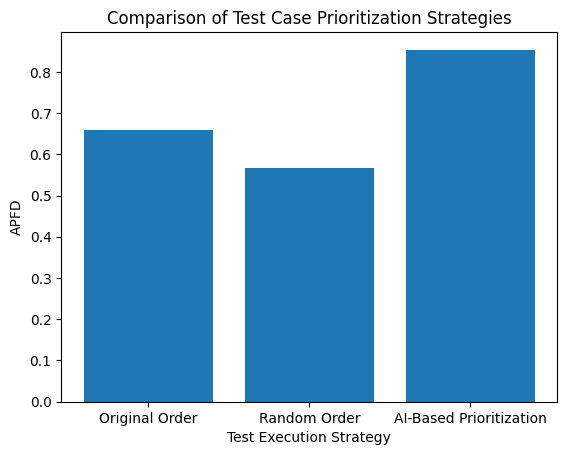

In [28]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(results_df["Strategy"], results_df["APFD"])
plt.xlabel("Test Execution Strategy")
plt.ylabel("APFD")
plt.title("Comparison of Test Case Prioritization Strategies")
plt.show()
